### Grammy Awards EDA

In [1]:
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
#Edit the .env file 
dotenv_path = os.path.join('..', 'config', 'postgres_sqlalchemy.env')
load_dotenv(dotenv_path=dotenv_path)

# Enviroment variables with os.getenv
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv('DB_PASS')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')

print(DB_NAME, DB_USER)

postgres airflow


In [3]:
def read_csv(path):
    return pd.read_csv(path)

def make_db_engine():
    return create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

def load_data(df, table_name):
    engine = make_db_engine()
    df.to_sql(table_name, con=engine, if_exists='replace', index=False)

def loading_data(path, table_name):
    df = read_csv(path)
    load_data(df, table_name)

# Make query and see it df
def query_data(sql_query):
    engine = make_db_engine()
    with engine.connect() as connection:
        return pd.read_sql(sql_query, connection)
    

Loading the data in the new table grammyAwards

In [4]:
loading_data('../csvs/the_grammy_awards.csv', 'grammyAwards')

Note: I use no limit here to take all the data, 4810 rows x 10 columns to the df

In [5]:
# Consulta
sql_query = 'SELECT * FROM "grammyAwards"'
df = query_data(sql_query)
df.head(5)

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


In [6]:
df.describe()

,year
count,4810.000000
mean,1995.566944
std,17.149720
min,1958.000000
25%,1983.000000
50%,1998.000000
75%,2010.000000
max,2019.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


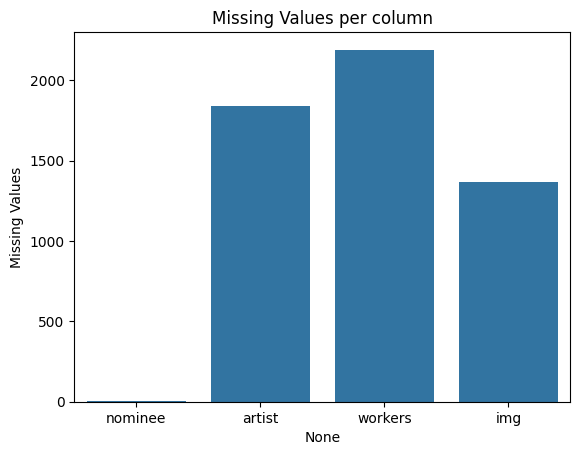

In [8]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]

sns.barplot(x=missing_data.index, y=missing_data.values)
plt.xticks(rotation=0)
plt.ylabel('Missing Values')
plt.title('Missing Values per column')
plt.show()